<a href="https://colab.research.google.com/github/laurehm/2025-m2-idl/blob/main/3-autodiff/tp-3-backprop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP: Simple implementation of backprop

_From [Dataflowr Module 2](https://dataflowr.github.io/website/modules/2b-automatic-differentiation/) by Marc Lelarge_

Here we implement a simple backpropagation algorithm with `numpy` for the following problem:

We generate points $(x_t,y_t)$ where $y_t= \exp(w^*x_t+b^*)$, i.e $y_t$ is obtained by applying a deterministic function to $x_t$ with parameters $w^*$ and $b^*$. Our goal is to recover the parameters $w^*$ and $b^*$ from the observations $(x_t,y_t)$.

[Last week](2-basics/linear-regression.ipynb), we computed the loss on the entire dataset at each iteration of the learning loop using vectorized operations. This is called **Batched Gradient Descent**.

At the other extreme, it is also possible to compute the gradient after a single data point to update the parameters. This is called **Stochastic Gradient Descent**.

## Stochastic Gradient Descent (SGD)

The total loss over the entire dataset is:
$$
L = \sum_t\underbrace{\left(\exp(w x_t+b)-y_t \right)^2}_{L_t}.
$$

Instead of computing the gradient over the **entire dataset** $\frac{\partial L}{\partial w} = \sum_t \frac{\partial L_t}{\partial w}$ at each iteration (which is expensive), we:

1. **Randomly pick one sample** $t$ at each iteration
2. Compute the gradient of **only that sample's loss**: $\frac{\partial L_t}{\partial w}$ and $\frac{\partial L_t}{\partial b}$
3. Update the parameters using this **single-sample gradient**

The SGD update loop is:

For each iteration $i$:
- Pick a random sample index $t \in \{1,\dots,n\}$
- Update parameters:

\begin{align*}
w_{i+1}&=w_{i}-\alpha\frac{\partial{L_t}}{\partial w} \\
b_{i+1}&=b_{i}-\alpha\frac{\partial{L_t}}{\partial b}
\end{align*}

where $\alpha>0$ is the **learning rate**.

Although each gradient $\frac{\partial L_t}{\partial w}$ is a noisy estimate of the true gradient $\frac{\partial L}{\partial w}$, on average it points in the right direction. Over many iterations, the parameters converge to the optimum.

In [1]:
# You do not need PyTorch for these practicals
import numpy as np
import matplotlib.pyplot as plt

In [2]:
w, b = 0.5, 2
xx = np.arange(0,1,.01)
yy = np.exp(w*xx+b)

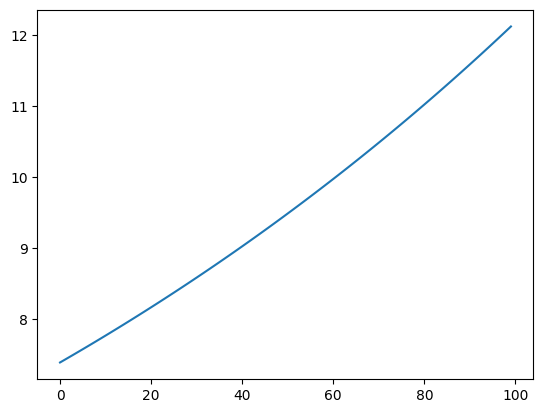

In [3]:
plt.plot(yy)

Following what we just saw in the course, you need to implement each of the basic operations: `(.*w), (.+b), exp(.)` with a forward method, a backward method and a step method (to update the parameter).

To help you, I have implemented the `(.+b)` operation as a Python class below:

In [4]:
class add_bias(object):
    def __init__(self,b):
        # initialize with a bias b
        self.b = b

    def forward(self, x):
        # return the result of adding the bias
        return x + self.b

    def backward(self,grad):
        # save the gradient (to update the bias in the step method) and return the gradient backward
        self.grad = grad
        return grad

    def step(self, learning_rate):
        # update the bias
        self.b -= learning_rate*self.grad

Consider now a simpler problem where you have $z_t = x_t+b^*$ and your task is to estimate $b^*$ by minimizing the loss $\sum_t(x_t+b-z_t)^2$ as a function of $b$ with SGD. You can use the `add_bias` defined above as follows:

In [5]:
# first compute the z_t with a true bias of 5:
zz = xx+5

#start with an initial guess of 1 for the bias:
My_add_bias = add_bias(1)

In [6]:
j = 10
# your prediction will be for each sample
z_pred = My_add_bias.forward(xx[j])
z_pred

np.float64(1.1)

In [7]:
# start with the gradient of the quadratic loss
grad = 2*(z_pred-zz[j])

In [8]:
# backpropagate the gradient to the parameter b
My_add_bias.backward(grad)

np.float64(-7.999999999999999)

In [9]:
# make an update of the bias
My_add_bias.step(1e-2)
My_add_bias.b

np.float64(1.08)

The code above corresponds to one SGD update.
Below, I coded the training loop for SGD where the update on the parameter is done each time you see a sample: for each sample $j$, you compute the associated

In [10]:
My_add_bias = add_bias(1)
estimated_b = [1]
for i in range(500):
    # take a random indice
    j = np.random.randint(1, len(xx))
    z_pred = My_add_bias.forward(xx[j])
    grad = 2*(z_pred-zz[j])
    _ = My_add_bias.backward(grad)
    My_add_bias.step(1e-2)
    estimated_b.append(My_add_bias.b)

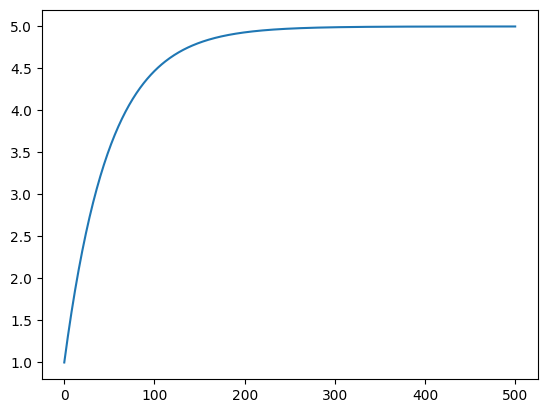

In [11]:
plt.plot(estimated_b)

Although SGD is computing a noisy version of the gradient, we see that SGD converges to the right solution in this case.

Now it is your turn!
Following what we just saw in the course, you need to implement each of the basic operations: `(.*w), exp(.)` with a forward method, a backward method and a step method.

**Remember**:

- _Forward pass_ (compute and store): $x$, $u = wx$, $v = u+b$, $\hat{y} = \exp(v)$, $\ell = (\hat{y}-y)^2$

- _Backward pass_ steps:

$$
\begin{align*}
&\text{1. Initialize:} & \frac{\partial \ell}{\partial \ell} &= 1\\\\
\\\\
&\text{2. Loss:} & \frac{\partial \ell}{\partial \hat{y}} &= \frac{\partial \ell}{\partial \ell} \cdot \frac{\partial \ell}{\partial \hat{y}} = 1 \cdot 2(\hat{y}-y) = 2(\hat{y}-y)\\\\
\\\\
&\text{3. Exponential:} & \frac{\partial \ell}{\partial v} &= \frac{\partial \ell}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial v} = 2(\hat{y}-y) \cdot \hat{y}\\\\
\\\\
&\text{4. Addition:} & \frac{\partial \ell}{\partial u} &= \frac{\partial \ell}{\partial v} \cdot \frac{\partial v}{\partial u} = 2(\hat{y}-y) \cdot \hat{y} \cdot 1\\\\
\\\\
&\text{5. Multiplication:} & \frac{\partial \ell}{\partial w} &= \frac{\partial \ell}{\partial u} \cdot \frac{\partial u}{\partial w} = 2(\hat{y}-y) \cdot \hat{y} \cdot x
\end{align*}
$$

In [12]:
class multiplication_weight(object):
    def __init__(self, w):
        # initialize with a weight w
        self.w=w

    def forward(self, x):
        # return the result of multiplying by weight
        self.x=x
        return self.w * x

    def backward(self,grad):
        # save the gradient (to update the weight in the step method) and return the gradient backward
        self.grad_w = grad * self.x
        return grad * self.w

    def step(self, learning_rate):
        # update the weight
        self.w -= learning_rate * self.grad_w

class my_exp(object):
    # no parameter
    def forward(self, x):
        # return exp(x)
        self.y = np.exp(x)
        return self.y

    def backward(self,grad):
        # return the gradient backward
        return grad * self.y

    def step(self, learning_rate):
        # any parameter to update?
        pass


Now, you will need to compose sequentially these operations and here you need to code a class composing operations. This class will have a forward, a backward and a step method and also a compute_loss method.

In [13]:
class my_composition(object):
    def __init__(self, layers):
        # initialize with all the operations (called layers here!) in the right order...
        self.layers = layers

    def forward(self, x):
        # apply the forward method of each layer
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def compute_loss(self, y_est, y_target):
        # use the L2 loss
        # return the loss and save the gradient of the loss
        self.y_est = y_est
        self.y_target = y_target

        loss = (y_est - y_target) ** 2

        self.grad_loss = 2 * (y_est - y_target)

        return loss

    def backward(self):
        # apply backprop sequentially, starting from the gradient of the loss
        # Hint: https://docs.python.org/3/library/functions.html#reversed
        grad = self.grad_loss

        for layer in reversed(self.layers):
            grad = layer.backward(grad)

    def step(self, learning_rate):
        # apply the step method of each layer
        for layer in self.layers:
            layer.step(learning_rate)


Now you need to code the 'training' loop. Keep track of the loss, weight and bias computed at each epoch.


In [14]:
my_fit = my_composition([multiplication_weight(1),add_bias(1), my_exp()])
learning_rate = 1e-4
losses =[]
ws = []
bs = []
for i in range(5000):
    # take a random indice
    j = np.random.randint(1, len(xx))
    # you can compare with
    #j = i % len(xx)
    # compute the estimated value of y from xx[j] with the current values of the parameters
    x = xx[j]
    y = yy[j]
    # compute the loss and save it
    #forward
    y_est = my_fit.forward(x)

    #loss
    loss = my_fit.compute_loss(y_est, y)
    losses.append(loss)

    #backward
    my_fit.backward()

    #update
    my_fit.step(learning_rate)

    #and save them
    ws.append(my_fit.layers[0].w)
    bs.append(my_fit.layers[1].b)

In [15]:
my_fit.layers[0].w

np.float64(0.5047166481516503)

In [16]:
my_fit.layers[1].b

np.float64(1.9970778883450588)

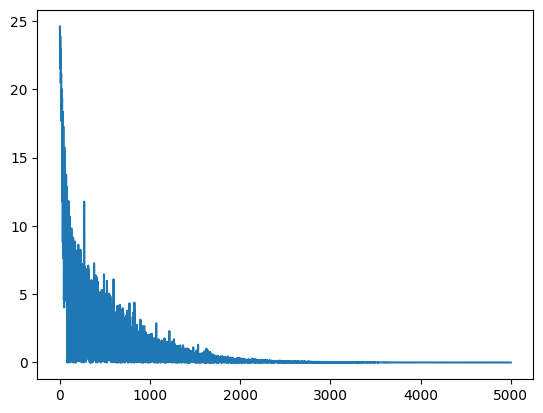

In [17]:
plt.plot(losses)

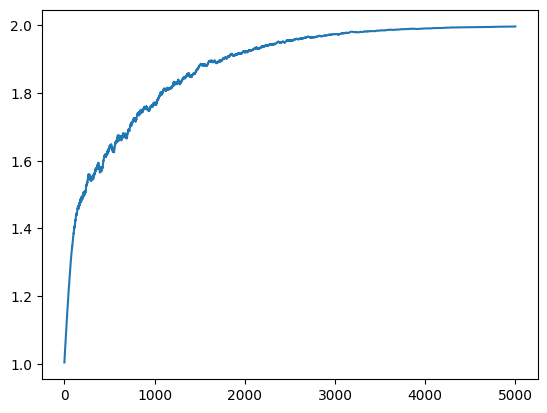

In [18]:
plt.plot(bs)

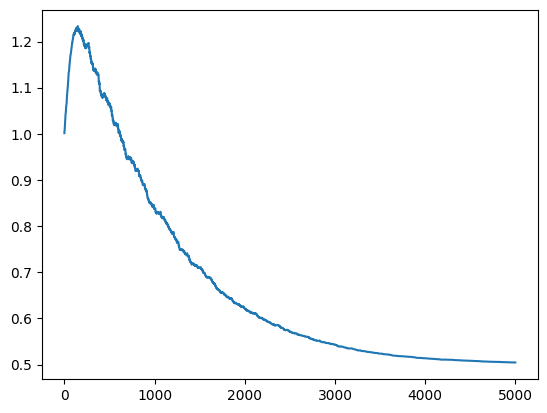

In [19]:
plt.plot(ws)

Now you understand how Pytorch deals with automatic differentiation!!

In [20]:
for x in [-1, 0, 1]:
    print(np.exp(0.5*x + 2), my_fit.forward(x))

4.4816890703380645 4.447584946440353
7.38905609893065 7.367495967881416
12.182493960703473 12.204375518491712
